In [ ]:
!pip install nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-BFl5WhcVtCO3T4HvCcNShkmej8MPWg2tJAXNK9BTePnMW93iVJeYwPPb5gBv16SVPaT7NFZqYh2uTNS8'
)

In [ ]:
#Prepare Train and test data from given data for which true value is available
def get_train_test(df, h):
    train = pd.DataFrame()
    test = pd.DataFrame()
    for category in df['unique_id'].unique():
        train_data = df[df['unique_id'] == category].iloc[:-h]
        test_data = df[df['unique_id'] == category].iloc[-h:]
        train = pd.concat([train, train_data])
        test = pd.concat([test, test_data])
    return train, test

#plot graph of Histroical points, current Actual and Predicted points.
def plot_graph(train_df, test_df):
    fig, axs = plt.subplots(len(train_df['unique_id'].unique()), figsize=(20, 20))

    train_df['ds'] = pd.to_datetime(train_df['ds'])
    test_df['ds'] = pd.to_datetime(test_df['ds'])

    for i, category in enumerate(train_df['unique_id'].unique()):
        ax = axs[i]
        train_1 = train_df[train_df['unique_id'] == category]
        test_1 = test_df[test_df['unique_id'] == category]
        ax.plot(train_1['ds'], train_1['y'], label='Training', color='blue')
        ax.plot(test_1['ds'], test_1['y'], label='Actual Test', color='green')
        ax.plot(test_1['ds'], test_1['TimeGPT'], label='Predicted Test', color='red')
        ax.set_title(f'Category {category}')
        ax.legend()
    plt.tight_layout()
    plt.show()

  #Calculate Error Metrics
def get_metrics(test_df):
    error = pd.DataFrame({'Metric' : ['MAE', 'MSE', 'RMSE', 'MAPE']})
    for i, category in enumerate(df['unique_id'].unique()):
        test_1 = test_df[test_df['unique_id'] == category]
        mae = mean_absolute_error(test_1['y'], test_1['TimeGPT'])
        mse = mean_squared_error(test_1['y'], test_1['TimeGPT'])
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(test_1['y'], test_1['TimeGPT']) * 100
        error[category] = [mae, mse, rmse, mape]
    error = error.round(3)
    return error


In [ ]:
# Read the data

df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')

df['ds'] = pd.to_datetime(df['ds'])

data, test = get_train_test(df, 24)
train, val = get_train_test(data, 48)


In [ ]:
# prompt: get the minimum and maximum date for BE time series

min_date = df[df['unique_id'] == 'NP']['ds'].min()
max_date = df[df['unique_id'] == 'NP']['ds'].max()

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")

df[df['unique_id'] == 'NP'].size


Minimum Date: 2018-10-15 00:00:00
Maximum Date: 2018-12-23 23:00:00


5040

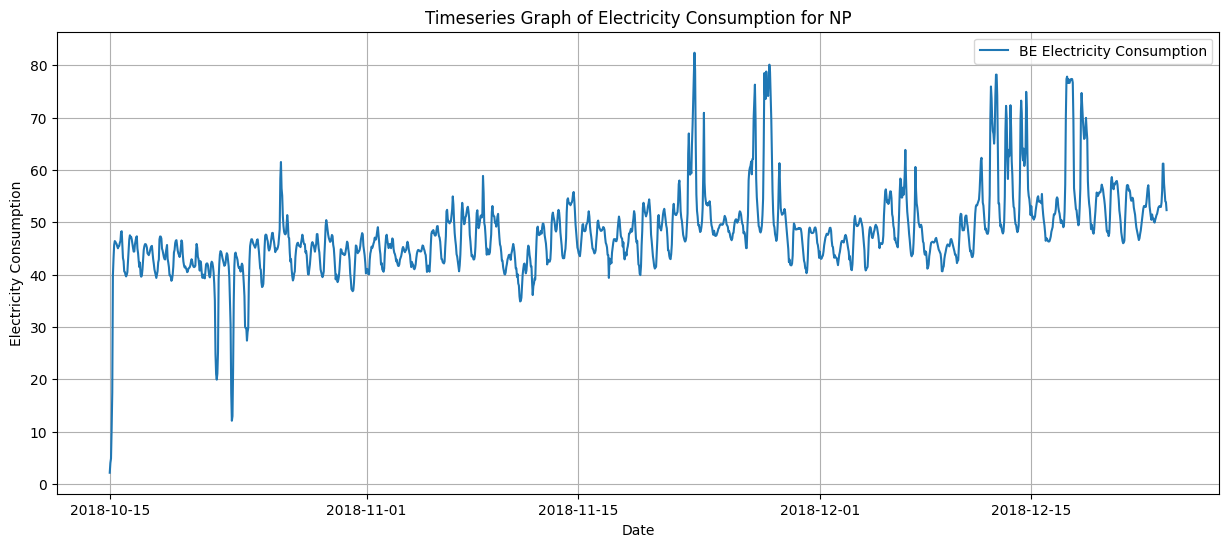

In [ ]:
# prompt: Can you plot the timeseries graph of BE

# Assuming 'df' is already loaded as in the provided code.

# ... (your existing code) ...

# Plotting the timeseries graph of BE (assuming 'BE' is a unique_id)
import matplotlib.pyplot as plt

be_data = df[df['unique_id'] == 'NP']  # Filter data for 'BE'

plt.figure(figsize=(15, 6))
plt.plot(be_data['ds'], be_data['y'], label='BE Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.title('Timeseries Graph of Electricity Consumption for NP')
plt.legend()
plt.grid(True)
plt.show()


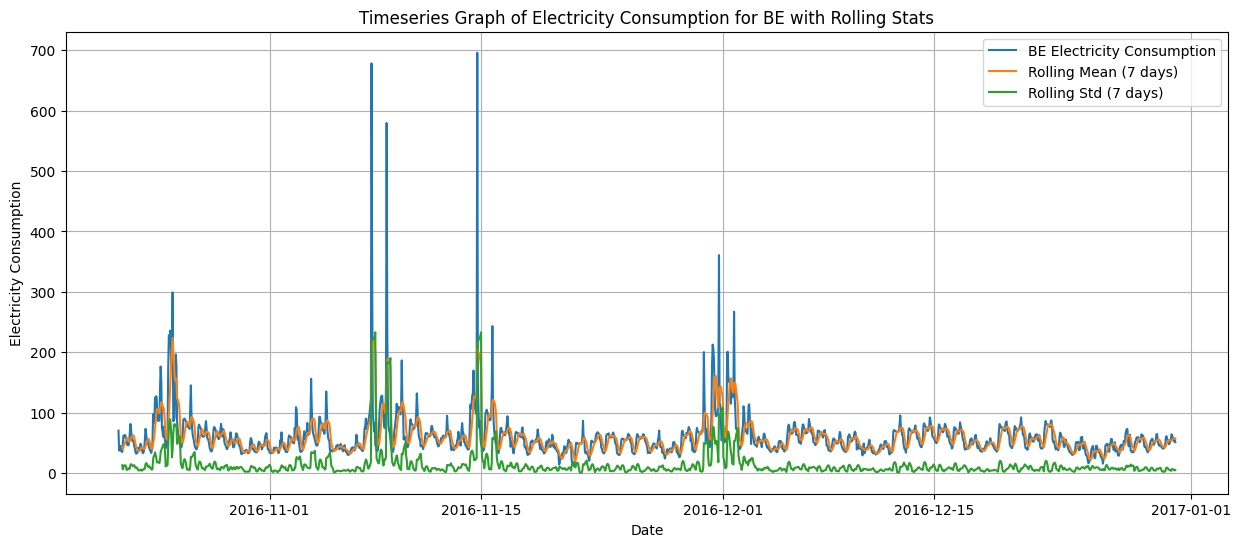

ADF Statistic: -3.500016
p-value: 0.007987
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

Strong evidence against the null hypothesis. Data is likely stationary.


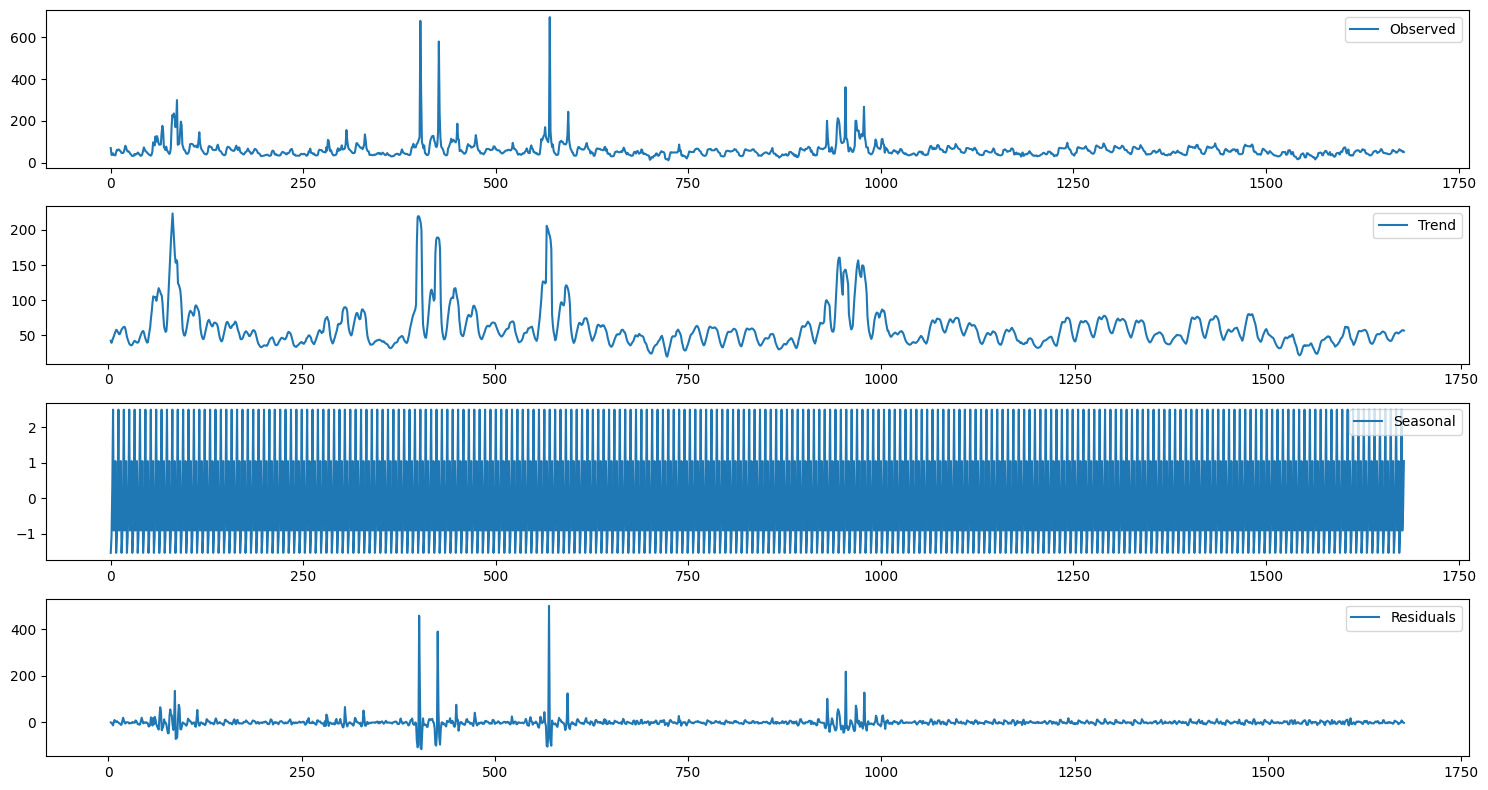

In [ ]:
# prompt: What is the nature of this timeseries?

import matplotlib.pyplot as plt
# Assuming 'df' is already loaded as in the provided code.

# ... (your existing code) ...

# Analyze the nature of the time series for 'BE'

be_data = df[df['unique_id'] == 'BE']

# Calculate rolling statistics (e.g., rolling mean and standard deviation)
be_data['rolling_mean'] = be_data['y'].rolling(window=7).mean() #7 day rolling mean
be_data['rolling_std'] = be_data['y'].rolling(window=7).std()

# Plot the time series with rolling statistics
plt.figure(figsize=(15, 6))
plt.plot(be_data['ds'], be_data['y'], label='BE Electricity Consumption')
plt.plot(be_data['ds'], be_data['rolling_mean'], label='Rolling Mean (7 days)')
plt.plot(be_data['ds'], be_data['rolling_std'], label='Rolling Std (7 days)')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.title('Timeseries Graph of Electricity Consumption for BE with Rolling Stats')
plt.legend()
plt.grid(True)
plt.show()


# Perform Augmented Dickey-Fuller test to check for stationarity.
from statsmodels.tsa.stattools import adfuller

result = adfuller(be_data['y'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results of the Augmented Dickey-Fuller test.
if result[1] <= 0.05:
    print("\nStrong evidence against the null hypothesis. Data is likely stationary.")
else:
    print("\nWeak evidence against the null hypothesis. Data is likely non-stationary.")

#Further analysis (decompose the time series to identify trend and seasonality)
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(be_data['y'], model='additive', period=7) # Assuming weekly seasonality, adjust if needed.


# Plot the decomposed components
plt.figure(figsize=(15, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend()
plt.tight_layout()
plt.show()


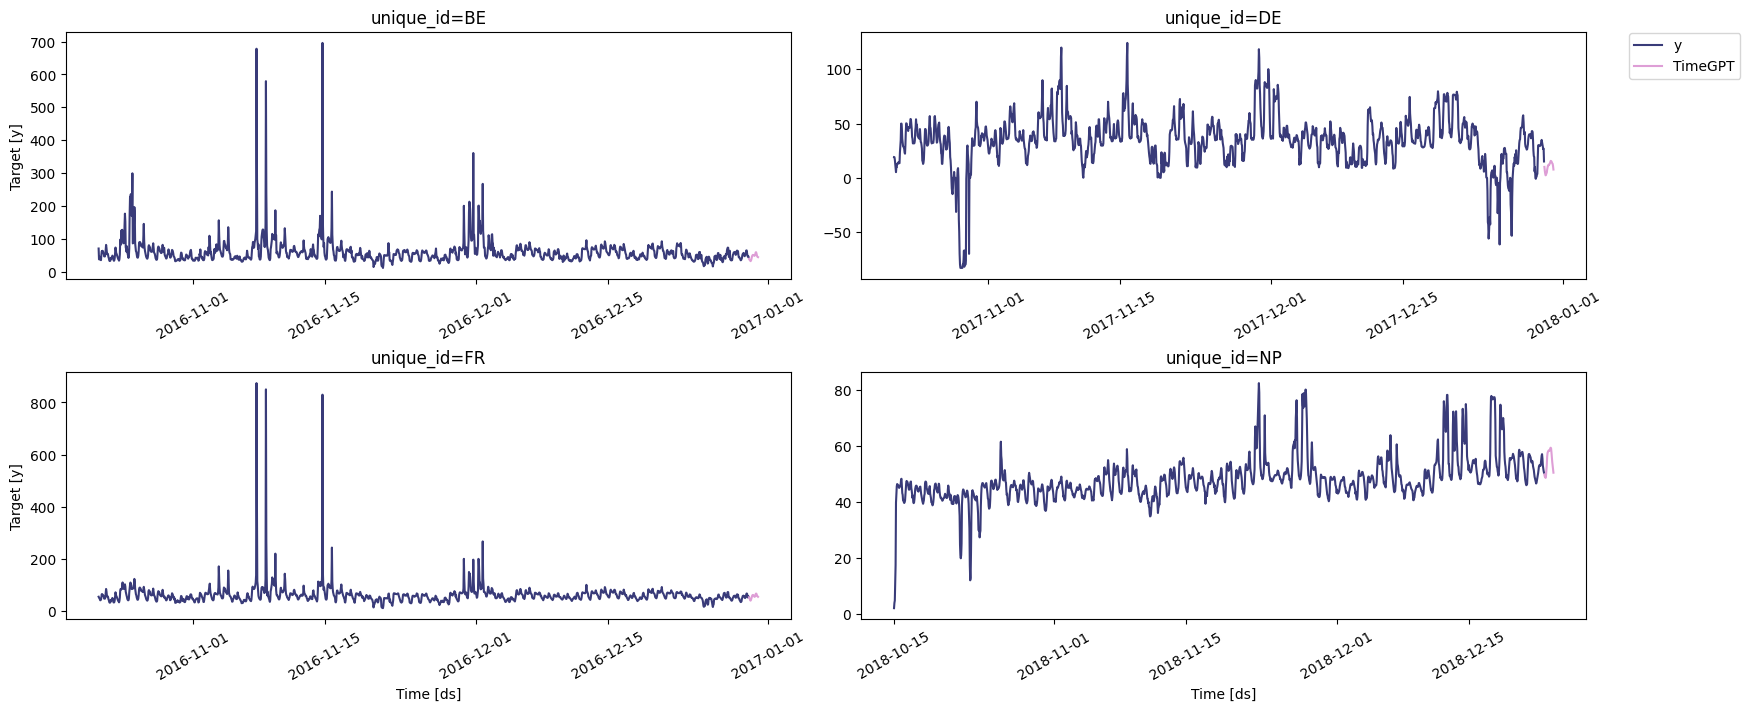

In [ ]:
# Forecast
forecast_df = nixtla_client.forecast(
    df=data,
    h=24,
    time_col='ds',
    target_col="y"
)

# Plot predictions
nixtla_client.plot(
    df=data,
    forecasts_df=forecast_df,
    time_col='ds',
    target_col='y'
)

In [ ]:
merged_df = pd.merge(forecast_df, test, on=['ds', 'unique_id'], how='inner')
get_metrics(merged_df)

,Metric,BE,DE,FR,NP
0,MAE,5.939,5.060,5.198,3.170
1,MSE,43.582,32.626,41.080,13.466
2,RMSE,6.602,5.712,6.409,3.670
3,MAPE,11.887,165.413,8.450,5.954


In [ ]:
# Apply boosting process (Iterative residual correction)
fcst_df = nixtla_client.forecast(train, h=48, id_col='unique_id', time_col='ds', target_col='y', add_history = True)
interm = pd.merge(data, fcst_df, on = ['unique_id', 'ds'], how='left')
interm['diff'] = interm['y'] - interm['TimeGPT']
interm.fillna(value = 0, inplace = True)
interm.drop(columns = ['TimeGPT'], inplace = True)
i = 0

while i < 40:
    interm_train, interm_val = get_train_test(interm, 48)

    # Prepare explanatory variables
    future_ex_vars_df = interm_val.drop(columns=['y'])
    future_ex_vars_df['diff'] = 0

    # Forecast with residual correction
    timegpt_fcst_df = nixtla_client.forecast(
        df=interm_train, X_df=future_ex_vars_df, h=48,
        id_col='unique_id', time_col='ds', target_col='y', add_history=True
    )

    # Merge forecast and compute new residuals
    interm = pd.merge(interm, timegpt_fcst_df, on=['unique_id', 'ds'], how='left')
    interm['diff'] = interm['y'] - interm['TimeGPT']
    interm.fillna(0, inplace=True)

    interm.drop(columns=['TimeGPT'], inplace=True)
    i += 1

In [ ]:
test['diff'] = 0

# Forecast on the test set using boosted model
boosted_fcst_test = nixtla_client.forecast(
    df=interm, X_df=test.drop(columns=['y']), h=24,
    id_col='unique_id', time_col='ds', target_col='y', add_history=True
)

# Merge with actual test values
test_boosted = pd.merge(test, boosted_fcst_test, on=['unique_id', 'ds'], how='left')

get_metrics(test_boosted)

,Metric,BE,DE,FR,NP
0,MAE,4.927,9.541,10.539,3.110
1,MSE,31.058,112.200,144.845,13.717
2,RMSE,5.573,10.592,12.035,3.704
3,MAPE,9.565,119.890,16.738,5.844
